<a href="https://colab.research.google.com/github/hyomee2/scooter-parking-detector/blob/main/models/yolov8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. 구글 드라이브 마운트

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 2. YOLOv8을 위한 ultralytics 설치

In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 31.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 77.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 57.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 110.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling

## 3. YOLOv8을 위한 데이터 디텍토리 구조 생성

In [ ]:
import os
import shutil
import random
from pathlib import Path

# 경로 설정
RAW_DIR = Path('/content/drive/MyDrive/데기인 팀플 7조/final_output/dataset/raw')
LABEL_DIR = Path('/content/drive/MyDrive/데기인 팀플 7조/final_output/dataset/labelled_data')
YOLO_DIR = Path('/content/drive/MyDrive/데기인 팀플 7조/final_output/dataset/yolo')
CLASSES = ['improper', 'noise', 'proper']
SPLITS = ['train', 'val', 'test']
SPLIT_RATIO = [0.8, 0.1, 0.1]

# 기존 YOLO 하위 디렉토리 삭제 후 생성
for split in SPLITS:
    split_dir = YOLO_DIR / split
    if split_dir.exists():
        shutil.rmtree(split_dir)  # 기존 폴더 통째로 삭제
    (split_dir / 'images').mkdir(parents=True, exist_ok=True)
    (split_dir / 'labels').mkdir(parents=True, exist_ok=True)

def split_and_copy_images():
    for cls in CLASSES:
        # 디렉터리 무시하고 파일만 필터링
        image_paths = [p for p in (RAW_DIR / cls).glob('*.*') if p.is_file()]
        random.shuffle(image_paths)

        total = len(image_paths)
        train_end = int(total * SPLIT_RATIO[0])
        val_end = train_end + int(total * SPLIT_RATIO[1])

        split_paths = {
            'train': image_paths[:train_end],
            'val': image_paths[train_end:val_end],
            'test': image_paths[val_end:]
        }

        for split, paths in split_paths.items():
            for img_path in paths:
                # 이미지 복사
                dst_img_path = YOLO_DIR / split / 'images' / img_path.name
                shutil.copy(img_path, dst_img_path)

                # 레이블 복사
                label_name = img_path.with_suffix('.txt').name
                label_src = LABEL_DIR / label_name
                label_dst = YOLO_DIR / split / 'labels' / label_name
                if label_src.exists():
                    shutil.copy(label_src, label_dst)
                else:
                    print(f'[경고] 레이블 파일 없음: {label_src}')

if __name__ == "__main__":
    split_and_copy_images()
    print("✅ 데이터 분할 및 복사 완료.")


[경고] 레이블 파일 없음: /content/drive/MyDrive/데기인 팀플 7조/final_output/dataset/labelled_data/hm43.txt
[경고] 레이블 파일 없음: /content/drive/MyDrive/데기인 팀플 7조/final_output/dataset/labelled_data/hm56.txt
[경고] 레이블 파일 없음: /content/drive/MyDrive/데기인 팀플 7조/final_output/dataset/labelled_data/hm3.txt
[경고] 레이블 파일 없음: /content/drive/MyDrive/데기인 팀플 7조/final_output/dataset/labelled_data/C041.txt
[경고] 레이블 파일 없음: /content/drive/MyDrive/데기인 팀플 7조/final_output/dataset/labelled_data/D023.txt
[경고] 레이블 파일 없음: /content/drive/MyDrive/데기인 팀플 7조/final_output/dataset/labelled_data/H098.txt
[경고] 레이블 파일 없음: /content/drive/MyDrive/데기인 팀플 7조/final_output/dataset/labelled_data/D017.txt
[경고] 레이블 파일 없음: /content/drive/MyDrive/데기인 팀플 7조/final_output/dataset/labelled_data/H045.txt
[경고] 레이블 파일 없음: /content/drive/MyDrive/데기인 팀플 7조/final_output/dataset/labelled_data/C009.txt
[경고] 레이블 파일 없음: /content/drive/MyDrive/데기인 팀플 7조/final_output/dataset/labe

In [ ]:
import yaml

def create_data_yaml():
    yaml_dict = {
        'train': str(YOLO_DIR / 'train' / 'images'),
        'val': str(YOLO_DIR / 'val' / 'images'),
        'nc': len(CLASSES),
        'names': CLASSES
    }
    yaml_path = YOLO_DIR / 'data.yaml'
    with open(yaml_path, 'w') as f:
        yaml.dump(yaml_dict, f)
    print(f"✅ data.yaml 생성 완료 → {yaml_path}")

if __name__ == "__main__":
    split_and_copy_images()
    create_data_yaml()  # yaml 파일 생성까지 추가
    print("✅ 데이터 분할 + yaml 파일까지 생성 완료.")

[경고] 레이블 파일 없음: /content/drive/MyDrive/데기인 팀플 7조/final_output/dataset/labelled_data/hm3.txt
[경고] 레이블 파일 없음: /content/drive/MyDrive/데기인 팀플 7조/final_output/dataset/labelled_data/hm56.txt
[경고] 레이블 파일 없음: /content/drive/MyDrive/데기인 팀플 7조/final_output/dataset/labelled_data/hm43.txt
[경고] 레이블 파일 없음: /content/drive/MyDrive/데기인 팀플 7조/final_output/dataset/labelled_data/C041.txt
[경고] 레이블 파일 없음: /content/drive/MyDrive/데기인 팀플 7조/final_output/dataset/labelled_data/D017.txt
[경고] 레이블 파일 없음: /content/drive/MyDrive/데기인 팀플 7조/final_output/dataset/labelled_data/H045.txt
[경고] 레이블 파일 없음: /content/drive/MyDrive/데기인 팀플 7조/final_output/dataset/labelled_data/C009.txt
[경고] 레이블 파일 없음: /content/drive/MyDrive/데기인 팀플 7조/final_output/dataset/labelled_data/H100.txt
[경고] 레이블 파일 없음: /content/drive/MyDrive/데기인 팀플 7조/final_output/dataset/labelled_data/H098.txt
[경고] 레이블 파일 없음: /content/drive/MyDrive/데기인 팀플 7조/final_output/dataset/labe

## 4. YOLOv8을 이용한 훈련 실행

In [ ]:
from ultralytics import YOLO
# 모델 로드 (사전 학습된 모델 사용)
model = YOLO('yolov8n.pt')

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 6.25M/6.25M [00:00<00:00, 124MB/s]


In [ ]:
import torch
yaml_path = YOLO_DIR / 'data.yaml'
# 훈련 실행
model.train(
    data=yaml_path,  # data.yaml 파일 경로
    epochs=300,  # 훈련 epoch 수
    patience = 30,
    imgsz=640,  # 이미지 크기 (가장 일반적인 크기가 640)
    batch=32,  # 배치 크기

    # Learning rate schedule
    lr0=0.02,      # 초기 learning rate → 약간 높게 시작해서 빠른 탐색 유도
    lrf=0.01,      # 최종 learning rate multiplier (0.02 * 0.01 = 0.0002 수준까지 감소)
    warmup_epochs=5,


    # 증강
    # degrees=15.0, # ±15도 내외 회전 (= Rotation_range=15)
    translate=0.1, # 수평/수직 이동 (각각 이미지 크기의 10%) (= width_shift_range=0.1 & height_shift_range=0.1)
    fliplr=1.0, # 좌우 반전 (horizontal_flip=True)
    scale=0.2, # 확대/축소 (20% 내외로 확대/축소) (= zoom_range=0.2 )
    hsv_v=0.2, # 밝기 변화 조정 (brightness_range=[0.8, 1.2]과 비슷하게 맞춤)
    augment=True,        # 기본 augment 활성화
    mosaic=0.3,
    mixup=0.2,

    project='/content/drive/MyDrive/result',  # 결과 저장 폴더
    name='yolov8n_finetune',    # 훈련 이름
    pretrained=True,            # 사전 학습된 모델 사용
    val=True                    # 검증 수행
)

Ultralytics 8.3.151 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/데기인 팀플 7조/final_output/dataset/yolo/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=300, erasing=0.4, exist_ok=False, fliplr=1.0, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.2, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.02, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.2, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=0.3, multi_scale=False, name=yolov8n_finetune5, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, pat

train: Scanning /content/drive/MyDrive/데기인 팀플 7조/final_output/dataset/yolo/train/labels.cache... 901 images, 11 backgrounds, 1 corrupt: 100%|██████████| 911/911 [00:00<?, ?it/s]

train: /content/drive/MyDrive/데기인 팀플 7조/final_output/dataset/yolo/train/images/D018.jpg: ignoring corrupt image/label: Label class 15 exceeds dataset class count 3. Possible class labels are 0-2
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 5.6±7.0 ms, read: 13.0±11.4 MB/s, size: 100.4 KB)


val: Scanning /content/drive/MyDrive/데기인 팀플 7조/final_output/dataset/yolo/val/labels.cache... 178 images, 1 backgrounds, 0 corrupt: 100%|██████████| 179/179 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/result/yolov8n_finetune5/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.02' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /content/drive/MyDrive/result/yolov8n_finetune5
Starting training for 300 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/300      6.24G      1.079      1.068      1.356         54        640: 100%|██████████| 29/29 [00:25<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.14it/s]

                   all        179        470      0.825      0.773      0.845      0.594



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/300      6.26G     0.9735     0.9547      1.287         45        640: 100%|██████████| 29/29 [00:28<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.09s/it]

                   all        179        470      0.825       0.76      0.838      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/300      6.26G     0.9639     0.9528      1.282         45        640: 100%|██████████| 29/29 [00:24<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.01it/s]

                   all        179        470      0.803      0.744      0.823      0.557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/300      6.26G     0.9805     0.9503       1.29         39        640: 100%|██████████| 29/29 [00:24<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.31s/it]

                   all        179        470      0.786       0.75      0.809      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/300      6.26G     0.9909     0.9377      1.292         58        640: 100%|██████████| 29/29 [00:23<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:04<00:00,  1.43s/it]

                   all        179        470      0.825      0.744      0.833      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/300      6.26G      1.046     0.9524      1.335         74        640: 100%|██████████| 29/29 [00:23<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:04<00:00,  1.35s/it]

                   all        179        470      0.646      0.688      0.694      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/300      6.26G      1.112      1.033      1.385         51        640: 100%|██████████| 29/29 [00:24<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.27s/it]

                   all        179        470      0.764      0.606       0.72      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/300      6.26G      1.091      1.003      1.367         78        640: 100%|██████████| 29/29 [00:24<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.01s/it]

                   all        179        470      0.781       0.76      0.817      0.538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/300      6.26G      1.055     0.9733      1.348         57        640: 100%|██████████| 29/29 [00:26<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.10it/s]

                   all        179        470      0.747       0.73      0.798      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/300      6.26G      1.048     0.9638      1.338         58        640: 100%|██████████| 29/29 [00:24<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.02it/s]

                   all        179        470      0.724      0.691       0.75      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/300      6.26G      1.027     0.9314      1.336         49        640: 100%|██████████| 29/29 [00:24<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.09it/s]

                   all        179        470      0.817      0.745      0.816      0.553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/300      6.26G     0.9959     0.9041      1.298         55        640: 100%|██████████| 29/29 [00:24<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.16it/s]

                   all        179        470      0.813        0.7      0.804      0.527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/300      6.26G      1.024     0.9359      1.334         56        640: 100%|██████████| 29/29 [00:25<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.16it/s]

                   all        179        470      0.766       0.73      0.809      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/300      6.26G      1.022      0.935      1.326         70        640: 100%|██████████| 29/29 [00:24<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.17it/s]

                   all        179        470      0.755      0.749      0.812      0.542



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/300      6.28G       1.01      0.889      1.299         50        640: 100%|██████████| 29/29 [00:25<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.18it/s]

                   all        179        470      0.789      0.755      0.812      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/300      6.28G     0.9876     0.8789      1.302         54        640: 100%|██████████| 29/29 [00:24<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.16it/s]

                   all        179        470      0.814      0.779      0.853      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/300      6.28G     0.9741     0.8718      1.293         59        640: 100%|██████████| 29/29 [00:26<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.21it/s]

                   all        179        470      0.836      0.779       0.86      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/300      6.29G     0.9395     0.8316      1.269         53        640: 100%|██████████| 29/29 [00:25<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.23it/s]

                   all        179        470       0.85       0.77      0.835      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/300      6.29G     0.9312     0.8336      1.261         38        640: 100%|██████████| 29/29 [00:24<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.21it/s]

                   all        179        470       0.82      0.755      0.843      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/300      6.29G     0.9072     0.7975      1.241         77        640: 100%|██████████| 29/29 [00:24<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.24it/s]

                   all        179        470      0.829      0.784      0.862        0.6



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/300      6.29G     0.9195      0.824      1.244         54        640: 100%|██████████| 29/29 [00:26<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.15it/s]

                   all        179        470      0.743      0.737      0.804      0.551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/300      6.29G     0.9402     0.8435      1.271         57        640: 100%|██████████| 29/29 [00:25<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.13it/s]

                   all        179        470      0.808      0.787      0.864      0.595



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/300      6.29G      0.934     0.8142      1.261         73        640: 100%|██████████| 29/29 [00:24<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.13it/s]

                   all        179        470      0.844      0.764      0.848      0.604



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/300      6.29G     0.9148     0.8016      1.256         61        640: 100%|██████████| 29/29 [00:25<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:04<00:00,  1.47s/it]

                   all        179        470      0.841      0.831      0.889      0.625



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/300      6.29G     0.8762     0.7724      1.226         59        640: 100%|██████████| 29/29 [00:25<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.10s/it]

                   all        179        470      0.888      0.783      0.866        0.6



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/300      6.29G     0.8998     0.7807      1.234         44        640: 100%|██████████| 29/29 [00:25<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:04<00:00,  1.60s/it]

                   all        179        470       0.87      0.786      0.881      0.614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/300      6.29G     0.8773     0.7907      1.225         68        640: 100%|██████████| 29/29 [00:27<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.11it/s]

                   all        179        470      0.806      0.819      0.868      0.602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/300      6.29G     0.8931     0.7939      1.224         53        640: 100%|██████████| 29/29 [00:28<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.04s/it]

                   all        179        470      0.883       0.79      0.882       0.62



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/300      6.29G     0.8846     0.7688      1.227         45        640: 100%|██████████| 29/29 [00:25<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:05<00:00,  1.84s/it]

                   all        179        470       0.83        0.8      0.864      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/300      6.29G     0.8498     0.7358      1.192         46        640: 100%|██████████| 29/29 [00:23<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:04<00:00,  1.42s/it]

                   all        179        470      0.862      0.785      0.877      0.635



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/300       6.3G     0.8291     0.7251        1.2         45        640: 100%|██████████| 29/29 [00:29<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.16it/s]

                   all        179        470      0.852      0.781      0.862      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/300      6.31G      0.874     0.7649      1.218         49        640: 100%|██████████| 29/29 [00:29<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:04<00:00,  1.54s/it]

                   all        179        470      0.835        0.8      0.855      0.591



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/300      6.31G     0.8382     0.7305      1.193         53        640: 100%|██████████| 29/29 [00:22<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.15s/it]

                   all        179        470      0.853      0.796      0.883      0.622



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/300      6.31G     0.8499     0.7132      1.202         56        640: 100%|██████████| 29/29 [00:25<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.33s/it]

                   all        179        470      0.852      0.802       0.88      0.619



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/300      6.31G     0.8431     0.7198       1.19         49        640: 100%|██████████| 29/29 [00:28<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.19it/s]

                   all        179        470      0.851      0.774      0.874       0.63



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/300      6.31G     0.8172     0.7004      1.175         60        640: 100%|██████████| 29/29 [00:26<00:00,  1.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.12it/s]

                   all        179        470      0.847      0.817      0.884      0.636



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/300      6.31G     0.8101     0.6964       1.17         56        640: 100%|██████████| 29/29 [00:27<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.20it/s]

                   all        179        470       0.85      0.809      0.869      0.635



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/300      6.31G     0.8351     0.7331      1.192         78        640: 100%|██████████| 29/29 [00:28<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.19s/it]

                   all        179        470      0.794       0.83      0.859      0.604



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/300      6.31G     0.8102     0.6994      1.174         37        640: 100%|██████████| 29/29 [00:25<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:04<00:00,  1.39s/it]

                   all        179        470      0.885        0.8      0.888      0.646



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/300      6.31G     0.8167     0.6997      1.178         56        640: 100%|██████████| 29/29 [00:25<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.01s/it]

                   all        179        470      0.865      0.835      0.889      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/300      6.31G     0.8032     0.6986      1.174         59        640: 100%|██████████| 29/29 [00:24<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.12it/s]

                   all        179        470      0.841      0.845      0.906      0.667



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/300      6.31G     0.7726     0.6658      1.148         40        640: 100%|██████████| 29/29 [00:26<00:00,  1.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.18it/s]

                   all        179        470      0.877      0.843      0.896      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/300      6.31G     0.7962     0.6751      1.155         47        640: 100%|██████████| 29/29 [00:26<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.21it/s]

                   all        179        470      0.906      0.802      0.909      0.655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/300      6.31G     0.7665     0.6637      1.138         52        640: 100%|██████████| 29/29 [00:26<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.27it/s]

                   all        179        470      0.877      0.781      0.872      0.634



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/300      6.31G     0.7615     0.6569      1.135         65        640: 100%|██████████| 29/29 [00:26<00:00,  1.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.08s/it]

                   all        179        470      0.857      0.817      0.897      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/300      6.31G     0.7886     0.6726       1.16         34        640: 100%|██████████| 29/29 [00:28<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.06s/it]

                   all        179        470      0.866      0.796      0.883      0.629



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/300      6.31G     0.7783      0.669      1.147         57        640: 100%|██████████| 29/29 [00:24<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:04<00:00,  1.52s/it]

                   all        179        470      0.801      0.855      0.879      0.641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/300      6.31G     0.7812     0.6783      1.151         71        640: 100%|██████████| 29/29 [00:24<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.23it/s]

                   all        179        470      0.876      0.839      0.899      0.659



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/300      6.31G     0.7364     0.6052      1.122         45        640: 100%|██████████| 29/29 [00:26<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.21it/s]

                   all        179        470      0.886      0.809      0.891      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/300      6.31G     0.7811     0.6639      1.156         67        640: 100%|██████████| 29/29 [00:26<00:00,  1.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.21it/s]

                   all        179        470      0.823      0.848      0.888      0.635



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/300      6.31G     0.7629     0.6527       1.14         46        640: 100%|██████████| 29/29 [00:27<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.10s/it]

                   all        179        470      0.873      0.834       0.89      0.658



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/300      6.31G     0.7685     0.6523      1.146         48        640: 100%|██████████| 29/29 [00:26<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.22s/it]

                   all        179        470      0.857      0.818      0.887      0.655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/300      6.31G     0.7672     0.6482      1.144         65        640: 100%|██████████| 29/29 [00:28<00:00,  1.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.19it/s]

                   all        179        470      0.883      0.838      0.897      0.671



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/300      6.31G     0.7363     0.6274       1.12         85        640: 100%|██████████| 29/29 [00:27<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.08it/s]

                   all        179        470      0.904      0.799      0.894       0.66



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/300      6.31G     0.7403     0.6272      1.123         58        640: 100%|██████████| 29/29 [00:25<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:07<00:00,  2.34s/it]

                   all        179        470      0.834      0.815      0.869      0.634



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/300      6.31G     0.7496     0.6286      1.138         46        640: 100%|██████████| 29/29 [00:24<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.19it/s]

                   all        179        470      0.823      0.848      0.901      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/300      6.31G     0.7051     0.6043      1.105         24        640: 100%|██████████| 29/29 [00:26<00:00,  1.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.04it/s]

                   all        179        470      0.844      0.847      0.894      0.631



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/300      6.31G     0.7281     0.6083      1.108         35        640: 100%|██████████| 29/29 [00:24<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.08s/it]

                   all        179        470      0.858      0.809       0.88      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/300      6.31G     0.7019     0.6001      1.102         42        640: 100%|██████████| 29/29 [00:26<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.26s/it]

                   all        179        470      0.882      0.823      0.897      0.654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/300      6.31G     0.7547     0.6431      1.141         46        640: 100%|██████████| 29/29 [00:28<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.16it/s]

                   all        179        470      0.868      0.797      0.897      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/300      6.31G     0.7026     0.5844      1.105         37        640: 100%|██████████| 29/29 [00:26<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.25it/s]

                   all        179        470      0.825      0.836      0.892      0.661



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/300      6.31G     0.7287     0.6151      1.123         53        640: 100%|██████████| 29/29 [00:25<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:06<00:00,  2.29s/it]

                   all        179        470       0.85      0.838      0.903      0.669



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/300      6.31G     0.7119     0.6162      1.109         42        640: 100%|██████████| 29/29 [00:24<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:04<00:00,  1.35s/it]

                   all        179        470      0.875       0.86      0.909      0.671



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/300      6.31G     0.7084     0.6003      1.107         47        640: 100%|██████████| 29/29 [00:28<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.26it/s]

                   all        179        470      0.803      0.831      0.865       0.63



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/300      6.31G     0.7246     0.6199      1.122         56        640: 100%|██████████| 29/29 [00:27<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.16it/s]

                   all        179        470      0.841      0.849      0.898       0.67



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/300      6.31G     0.6941     0.5884      1.087         75        640: 100%|██████████| 29/29 [00:25<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.24it/s]

                   all        179        470      0.894       0.79      0.893      0.664



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/300      6.31G     0.7047     0.5993      1.099         69        640: 100%|██████████| 29/29 [00:25<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:06<00:00,  2.14s/it]

                   all        179        470      0.882       0.84      0.906      0.669



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/300      6.31G     0.7034      0.596      1.111         40        640: 100%|██████████| 29/29 [00:23<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.05s/it]

                   all        179        470      0.865      0.787      0.892      0.668



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/300      6.31G     0.6946     0.5903      1.102         46        640: 100%|██████████| 29/29 [00:25<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:04<00:00,  1.45s/it]

                   all        179        470      0.843      0.864      0.905      0.671



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/300      6.31G     0.7099     0.5992      1.106         58        640: 100%|██████████| 29/29 [00:27<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.19it/s]

                   all        179        470      0.896      0.805      0.898      0.671



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/300      6.31G     0.6966     0.6004      1.104         58        640: 100%|██████████| 29/29 [00:26<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.08it/s]

                   all        179        470      0.893      0.816      0.906      0.676



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/300      6.31G     0.6875     0.5863      1.096         51        640: 100%|██████████| 29/29 [00:29<00:00,  1.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.15it/s]

                   all        179        470      0.893      0.781      0.895      0.665



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/300      6.31G     0.7027     0.5891      1.104         43        640: 100%|██████████| 29/29 [00:28<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.33s/it]

                   all        179        470      0.836      0.833      0.889      0.648



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/300      6.31G       0.67     0.5596      1.077         53        640: 100%|██████████| 29/29 [00:26<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.13s/it]

                   all        179        470      0.893      0.817      0.903       0.67



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/300      6.31G     0.6712     0.5583      1.077         73        640: 100%|██████████| 29/29 [00:24<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:04<00:00,  1.61s/it]

                   all        179        470       0.84      0.845      0.899      0.666



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/300      6.31G     0.6763     0.5685      1.096         41        640: 100%|██████████| 29/29 [00:24<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.09it/s]

                   all        179        470       0.87       0.84      0.907      0.679



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/300      6.31G     0.6833     0.5624      1.085         67        640: 100%|██████████| 29/29 [00:28<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.11it/s]

                   all        179        470      0.899       0.81      0.885       0.65



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/300      6.31G     0.6774     0.5631      1.081         44        640: 100%|██████████| 29/29 [00:25<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.22it/s]

                   all        179        470      0.866      0.838      0.901      0.668



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/300      6.31G     0.6498     0.5446      1.065         47        640: 100%|██████████| 29/29 [00:25<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.10it/s]

                   all        179        470      0.848      0.843      0.893       0.67



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/300      6.31G      0.669     0.5564      1.079         56        640: 100%|██████████| 29/29 [00:27<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.07it/s]

                   all        179        470      0.845      0.868      0.905      0.668



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/300      6.31G     0.6844     0.5679       1.08         58        640: 100%|██████████| 29/29 [00:26<00:00,  1.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.11s/it]

                   all        179        470      0.895      0.815      0.909      0.678



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/300      6.31G      0.669     0.5641      1.082         42        640: 100%|██████████| 29/29 [00:23<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:04<00:00,  1.62s/it]

                   all        179        470      0.824      0.877      0.909      0.673



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/300      6.31G     0.6764     0.5658       1.08         49        640: 100%|██████████| 29/29 [00:23<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.21s/it]

                   all        179        470      0.901      0.834      0.918      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/300      6.31G     0.6662     0.5539      1.078         56        640: 100%|██████████| 29/29 [00:28<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.08s/it]

                   all        179        470       0.86      0.848      0.908      0.682



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/300      6.31G     0.6613      0.562      1.082         53        640: 100%|██████████| 29/29 [00:27<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.04it/s]

                   all        179        470      0.895      0.823      0.911      0.679



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/300      6.31G     0.6556     0.5506      1.064         58        640: 100%|██████████| 29/29 [00:26<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.16it/s]

                   all        179        470      0.902      0.845      0.915      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/300      6.31G     0.6585      0.558      1.074         75        640: 100%|██████████| 29/29 [00:26<00:00,  1.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.18it/s]

                   all        179        470       0.87      0.845      0.906       0.66



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/300      6.31G     0.6648     0.5574       1.08         47        640: 100%|██████████| 29/29 [00:26<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.24it/s]

                   all        179        470       0.85      0.845      0.896      0.673



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/300      6.31G     0.6447     0.5439      1.071         44        640: 100%|██████████| 29/29 [00:25<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.20s/it]

                   all        179        470      0.886       0.83      0.911      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/300      6.31G     0.6442     0.5513      1.068         87        640: 100%|██████████| 29/29 [00:28<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.07it/s]

                   all        179        470      0.869      0.834      0.904      0.672



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/300      6.31G     0.6579     0.5542      1.081         38        640: 100%|██████████| 29/29 [00:24<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.11it/s]

                   all        179        470      0.916      0.817      0.913      0.685



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/300      6.31G     0.6382     0.5391      1.054         57        640: 100%|██████████| 29/29 [00:26<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.13it/s]

                   all        179        470      0.887      0.834      0.914      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/300      6.31G     0.6353     0.5255      1.061         50        640: 100%|██████████| 29/29 [00:26<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.08it/s]

                   all        179        470      0.875      0.833      0.911      0.682



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/300      6.31G     0.6695     0.5768      1.082         62        640: 100%|██████████| 29/29 [00:26<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.12it/s]

                   all        179        470      0.873      0.848      0.905      0.676



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/300      6.31G      0.661     0.5516      1.078         47        640: 100%|██████████| 29/29 [00:27<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.05s/it]

                   all        179        470      0.903      0.804       0.89      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/300      6.31G     0.6467     0.5365      1.061         54        640: 100%|██████████| 29/29 [00:26<00:00,  1.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.17s/it]

                   all        179        470      0.856      0.861      0.909       0.67



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/300      6.31G     0.6516     0.5508      1.071         42        640: 100%|██████████| 29/29 [00:27<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:04<00:00,  1.48s/it]

                   all        179        470      0.905      0.838      0.915      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/300      6.31G     0.6243     0.5238      1.046         54        640: 100%|██████████| 29/29 [00:25<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.11it/s]

                   all        179        470      0.919      0.798      0.916        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/300      6.31G     0.6306     0.5315      1.055         55        640: 100%|██████████| 29/29 [00:29<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.19it/s]

                   all        179        470      0.894      0.819      0.911      0.682



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/300      6.31G     0.6219      0.533      1.056         56        640: 100%|██████████| 29/29 [00:27<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.02s/it]

                   all        179        470      0.888       0.83      0.904      0.679



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/300      6.31G     0.6174     0.5216      1.044         46        640: 100%|██████████| 29/29 [00:25<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.25s/it]

                   all        179        470      0.885       0.83      0.906      0.675



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/300      6.31G     0.6349     0.5462      1.062         49        640: 100%|██████████| 29/29 [00:26<00:00,  1.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.15s/it]

                   all        179        470      0.866      0.822      0.895      0.663



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/300      6.31G     0.6252     0.5284      1.056         51        640: 100%|██████████| 29/29 [00:26<00:00,  1.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.16it/s]

                   all        179        470      0.863      0.832      0.904      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/300      6.31G     0.6249     0.5092      1.055         59        640: 100%|██████████| 29/29 [00:28<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.11it/s]

                   all        179        470      0.896      0.846      0.919      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/300      6.31G     0.6218     0.5227      1.052         75        640: 100%|██████████| 29/29 [00:24<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.11it/s]

                   all        179        470      0.894      0.845       0.92       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/300      6.31G     0.6176     0.5202      1.046         58        640: 100%|██████████| 29/29 [00:26<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.00s/it]

                   all        179        470      0.892      0.815      0.909      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/300      6.31G     0.6277     0.5328      1.051         62        640: 100%|██████████| 29/29 [00:28<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.01it/s]

                   all        179        470      0.921      0.794      0.908      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/300      6.31G     0.6158     0.5217      1.045         42        640: 100%|██████████| 29/29 [00:24<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.33s/it]

                   all        179        470      0.888      0.832      0.916      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/300      6.31G      0.615     0.5263      1.047         41        640: 100%|██████████| 29/29 [00:26<00:00,  1.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.04s/it]

                   all        179        470      0.895       0.82      0.911      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/300      6.31G     0.5846     0.4876      1.025         31        640: 100%|██████████| 29/29 [00:26<00:00,  1.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.08it/s]

                   all        179        470      0.899      0.832      0.906       0.68



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/300      6.31G     0.6316     0.5297       1.06         44        640: 100%|██████████| 29/29 [00:29<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:05<00:00,  1.71s/it]

                   all        179        470      0.905      0.821      0.913      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/300      6.31G     0.6197     0.5127      1.045         54        640: 100%|██████████| 29/29 [00:24<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.18s/it]

                   all        179        470      0.851       0.85      0.911       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/300      6.31G     0.6335     0.5291      1.071         51        640: 100%|██████████| 29/29 [00:26<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.18s/it]

                   all        179        470      0.905      0.833      0.913      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/300      6.31G     0.6128     0.5114      1.047         85        640: 100%|██████████| 29/29 [00:28<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.15it/s]

                   all        179        470      0.898      0.811      0.895      0.676



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/300      6.31G     0.6007     0.5039      1.044         55        640: 100%|██████████| 29/29 [00:27<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.18it/s]

                   all        179        470      0.862      0.861      0.899      0.671



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/300      6.31G     0.6029     0.4958      1.039         41        640: 100%|██████████| 29/29 [00:27<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.09it/s]

                   all        179        470      0.855      0.854      0.911       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/300      6.31G     0.6071     0.5142      1.049         51        640: 100%|██████████| 29/29 [00:26<00:00,  1.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.07it/s]

                   all        179        470        0.9      0.832      0.908       0.68



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/300      6.31G     0.6055      0.507      1.044         53        640: 100%|██████████| 29/29 [00:26<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.23s/it]

                   all        179        470      0.907      0.838      0.914      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/300      6.31G     0.6007     0.5035      1.039         62        640: 100%|██████████| 29/29 [00:26<00:00,  1.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:05<00:00,  1.89s/it]

                   all        179        470      0.883      0.851      0.912      0.682



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/300      6.31G     0.5993     0.5072      1.033         59        640: 100%|██████████| 29/29 [00:25<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.12it/s]

                   all        179        470      0.888      0.842      0.918      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/300      6.31G     0.5918     0.5019      1.041         45        640: 100%|██████████| 29/29 [00:29<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.02it/s]

                   all        179        470      0.899      0.847      0.918      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/300      6.31G     0.6132     0.5125      1.045         61        640: 100%|██████████| 29/29 [00:27<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:04<00:00,  1.35s/it]

                   all        179        470      0.885      0.849      0.915      0.685



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/300      6.31G     0.6005     0.5018      1.036         49        640: 100%|██████████| 29/29 [00:26<00:00,  1.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.01it/s]

                   all        179        470        0.9      0.832      0.922        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/300      6.31G     0.5796      0.484      1.028         52        640: 100%|██████████| 29/29 [00:25<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:04<00:00,  1.55s/it]

                   all        179        470      0.881      0.855      0.923       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/300      6.31G     0.6092     0.5085      1.056         71        640: 100%|██████████| 29/29 [00:25<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.10it/s]

                   all        179        470      0.871      0.847       0.91      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/300      6.31G     0.5711     0.4856       1.03         53        640: 100%|██████████| 29/29 [00:25<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.12it/s]

                   all        179        470      0.882      0.853      0.916      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/300      6.31G     0.5983     0.5032      1.044         57        640: 100%|██████████| 29/29 [00:26<00:00,  1.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.09it/s]

                   all        179        470      0.891      0.838      0.919      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/300      6.31G     0.6149     0.5106       1.05         79        640: 100%|██████████| 29/29 [00:25<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.29s/it]

                   all        179        470      0.899      0.848      0.918      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/300      6.31G     0.5943     0.4954      1.038         49        640: 100%|██████████| 29/29 [00:27<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.27s/it]

                   all        179        470       0.92      0.828      0.912      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/300      6.31G     0.5982     0.5015      1.047         29        640: 100%|██████████| 29/29 [00:26<00:00,  1.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.05it/s]

                   all        179        470      0.888      0.846      0.921        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/300      6.31G     0.5555     0.4685      1.009         58        640: 100%|██████████| 29/29 [00:26<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.18it/s]

                   all        179        470      0.872      0.864      0.909      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/300      6.31G     0.5818     0.4876      1.027         63        640: 100%|██████████| 29/29 [00:26<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:04<00:00,  1.42s/it]

                   all        179        470      0.877      0.866      0.924      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/300      6.31G     0.5707     0.4779      1.028         39        640: 100%|██████████| 29/29 [00:24<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.11it/s]

                   all        179        470      0.901      0.837      0.915      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/300      6.31G     0.5664     0.4757      1.025         44        640: 100%|██████████| 29/29 [00:28<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.16it/s]

                   all        179        470      0.919      0.809      0.913      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/300      6.31G     0.5846     0.4916      1.029         55        640: 100%|██████████| 29/29 [00:26<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.06s/it]

                   all        179        470      0.888       0.84       0.92      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/300      6.31G     0.5639     0.4697      1.026         53        640: 100%|██████████| 29/29 [00:27<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.15s/it]

                   all        179        470      0.854      0.857      0.914      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/300      6.31G     0.5712     0.4872      1.025         57        640: 100%|██████████| 29/29 [00:28<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.07it/s]

                   all        179        470      0.865      0.879      0.919      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/300      6.31G     0.5571     0.4687      1.017         46        640: 100%|██████████| 29/29 [00:24<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.14it/s]

                   all        179        470      0.858      0.877      0.926      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/300      6.31G     0.5848     0.4953      1.032         63        640: 100%|██████████| 29/29 [00:27<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.05it/s]

                   all        179        470      0.884      0.842      0.919      0.682



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/300      6.31G      0.549     0.4671      1.012         30        640: 100%|██████████| 29/29 [00:26<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.17it/s]

                   all        179        470      0.879      0.857       0.92      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/300      6.31G     0.5757     0.4763      1.032         55        640: 100%|██████████| 29/29 [00:27<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.03it/s]

                   all        179        470      0.891      0.853       0.92      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/300      6.31G     0.5752     0.4812      1.024         25        640: 100%|██████████| 29/29 [00:27<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.30s/it]

                   all        179        470      0.889      0.864      0.927      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/300      6.31G     0.5785     0.4804      1.033         49        640: 100%|██████████| 29/29 [00:27<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.15s/it]

                   all        179        470      0.895      0.847      0.921      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/300      6.31G     0.5825     0.4792      1.028         33        640: 100%|██████████| 29/29 [00:26<00:00,  1.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.05s/it]

                   all        179        470      0.899      0.851      0.923      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/300      6.31G     0.5662      0.479      1.021         69        640: 100%|██████████| 29/29 [00:25<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.20it/s]

                   all        179        470      0.869      0.879      0.917      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/300      6.31G     0.5635     0.4826      1.024         62        640: 100%|██████████| 29/29 [00:27<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.03it/s]

                   all        179        470      0.906       0.86      0.928      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/300      6.31G     0.5647     0.4632      1.024         70        640: 100%|██████████| 29/29 [00:27<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.09s/it]

                   all        179        470      0.913      0.846      0.927      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/300      6.31G     0.5472     0.4516       1.01         55        640: 100%|██████████| 29/29 [00:25<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:04<00:00,  1.40s/it]

                   all        179        470      0.884      0.849      0.919      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/300      6.31G     0.5384     0.4482      1.002         55        640: 100%|██████████| 29/29 [00:24<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.16s/it]

                   all        179        470       0.89      0.827       0.91      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/300      6.31G     0.5424     0.4649      1.002         34        640: 100%|██████████| 29/29 [00:26<00:00,  1.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.13it/s]

                   all        179        470      0.903      0.828       0.91      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    151/300      6.31G     0.5643     0.4751      1.026         52        640: 100%|██████████| 29/29 [00:27<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:04<00:00,  1.59s/it]

                   all        179        470      0.893       0.83      0.909      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    152/300      6.31G     0.5567      0.471      1.018         60        640: 100%|██████████| 29/29 [00:25<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.20it/s]

                   all        179        470      0.862      0.864      0.918      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    153/300      6.31G     0.5656     0.4786      1.027         47        640: 100%|██████████| 29/29 [00:28<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.10it/s]

                   all        179        470      0.873      0.857      0.922      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    154/300      6.31G     0.5488     0.4424      1.008         54        640: 100%|██████████| 29/29 [00:26<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.24it/s]

                   all        179        470      0.882      0.849      0.917      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    155/300      6.31G     0.5502     0.4563      1.018         50        640: 100%|██████████| 29/29 [00:27<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.23s/it]

                   all        179        470      0.889      0.849      0.912      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    156/300      6.31G     0.5555     0.4637      1.024         55        640: 100%|██████████| 29/29 [00:24<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.31s/it]

                   all        179        470      0.872      0.866      0.919      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    157/300      6.31G     0.5496     0.4588      1.011         42        640: 100%|██████████| 29/29 [00:26<00:00,  1.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.22it/s]

                   all        179        470      0.882      0.857       0.92      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    158/300      6.31G      0.555      0.465      1.024         49        640: 100%|██████████| 29/29 [00:28<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.09it/s]

                   all        179        470      0.862      0.857      0.909      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    159/300      6.31G     0.5515     0.4607      1.013         66        640: 100%|██████████| 29/29 [00:27<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.43it/s]

                   all        179        470      0.911      0.834      0.921      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    160/300      6.31G     0.5312      0.448     0.9962         38        640: 100%|██████████| 29/29 [00:26<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.27it/s]

                   all        179        470      0.895      0.837      0.915      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    161/300      6.31G     0.5409     0.4519      1.006         47        640: 100%|██████████| 29/29 [00:24<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.20it/s]

                   all        179        470      0.912      0.816      0.912      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    162/300      6.31G     0.5312     0.4487      1.007         41        640: 100%|██████████| 29/29 [00:28<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.27s/it]

                   all        179        470      0.896      0.855      0.922      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    163/300      6.31G     0.5205     0.4349          1         70        640: 100%|██████████| 29/29 [00:25<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.10s/it]

                   all        179        470       0.89      0.846      0.907      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    164/300      6.31G     0.5343     0.4412      1.014         36        640: 100%|██████████| 29/29 [00:27<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.11it/s]

                   all        179        470      0.886       0.86      0.912      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    165/300      6.31G     0.5356      0.447      1.007         42        640: 100%|██████████| 29/29 [00:27<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.09it/s]

                   all        179        470      0.864      0.864      0.918      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    166/300      6.31G     0.5225     0.4405     0.9957         50        640: 100%|██████████| 29/29 [00:29<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.16it/s]

                   all        179        470      0.894      0.872      0.925      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    167/300      6.31G     0.5278     0.4429     0.9976         67        640: 100%|██████████| 29/29 [00:25<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.18s/it]

                   all        179        470      0.889      0.849      0.917      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    168/300      6.31G     0.5491     0.4511      1.015         49        640: 100%|██████████| 29/29 [00:26<00:00,  1.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.28s/it]

                   all        179        470      0.888      0.857      0.916      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    169/300      6.31G     0.5343     0.4546      1.001         42        640: 100%|██████████| 29/29 [00:23<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:04<00:00,  1.65s/it]

                   all        179        470      0.877      0.863      0.916       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    170/300      6.31G     0.5343     0.4502      1.005         26        640: 100%|██████████| 29/29 [00:25<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.09it/s]

                   all        179        470      0.881      0.857      0.914      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    171/300      6.31G     0.5239     0.4302     0.9982         45        640: 100%|██████████| 29/29 [00:26<00:00,  1.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.06it/s]

                   all        179        470      0.873      0.853      0.922       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    172/300      6.31G     0.5249     0.4393     0.9924         49        640: 100%|██████████| 29/29 [00:26<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.18it/s]

                   all        179        470      0.908      0.851      0.917      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    173/300      6.31G     0.5199     0.4405     0.9989         56        640: 100%|██████████| 29/29 [00:28<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.14s/it]

                   all        179        470      0.892      0.862      0.928       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    174/300      6.31G     0.5382     0.4534      1.016         64        640: 100%|██████████| 29/29 [00:25<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.14s/it]

                   all        179        470      0.894      0.845      0.917      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    175/300      6.31G     0.5102     0.4326      0.989         51        640: 100%|██████████| 29/29 [00:27<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.10it/s]

                   all        179        470      0.899      0.848       0.92      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    176/300      6.31G     0.5432      0.457      1.009         86        640: 100%|██████████| 29/29 [00:27<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.05it/s]

                   all        179        470      0.869      0.862      0.923      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    177/300      6.31G     0.5059     0.4244     0.9847         27        640: 100%|██████████| 29/29 [00:27<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.12it/s]

                   all        179        470      0.866      0.881      0.922       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    178/300      6.31G     0.5373     0.4445      1.001         51        640: 100%|██████████| 29/29 [00:25<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.04it/s]

                   all        179        470      0.851      0.875      0.913      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    179/300      6.31G     0.5417     0.4526      1.004         75        640: 100%|██████████| 29/29 [00:25<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.01it/s]

                   all        179        470      0.909      0.836      0.927      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    180/300      6.31G     0.5118     0.4303      0.986         40        640: 100%|██████████| 29/29 [00:29<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.33it/s]

                   all        179        470      0.872      0.857      0.918      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    181/300      6.31G     0.5016     0.4167      0.985         26        640: 100%|██████████| 29/29 [00:27<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.14it/s]

                   all        179        470      0.886      0.851      0.917       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    182/300      6.31G     0.5104      0.426     0.9921         57        640: 100%|██████████| 29/29 [00:26<00:00,  1.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.09it/s]

                   all        179        470      0.905      0.849      0.915      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    183/300      6.31G     0.5169     0.4388      1.001         39        640: 100%|██████████| 29/29 [00:27<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.09it/s]

                   all        179        470      0.901      0.851       0.92      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    184/300      6.31G     0.4955     0.4201       0.98         56        640: 100%|██████████| 29/29 [00:27<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.09it/s]

                   all        179        470      0.886      0.875      0.925      0.725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    185/300      6.31G     0.5066     0.4335     0.9917         41        640: 100%|██████████| 29/29 [00:25<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:07<00:00,  2.39s/it]

                   all        179        470      0.894      0.865      0.932      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    186/300      6.31G     0.5171     0.4348     0.9969         48        640: 100%|██████████| 29/29 [00:26<00:00,  1.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.20it/s]

                   all        179        470      0.877      0.866      0.929      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    187/300      6.31G     0.4978     0.4288     0.9858         32        640: 100%|██████████| 29/29 [00:26<00:00,  1.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.12it/s]

                   all        179        470      0.886      0.864      0.925      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    188/300      6.31G     0.5112     0.4342     0.9998         44        640: 100%|██████████| 29/29 [00:26<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.08it/s]

                   all        179        470       0.85      0.885      0.928      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    189/300      6.31G     0.5149     0.4241     0.9945         43        640: 100%|██████████| 29/29 [00:27<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.22it/s]

                   all        179        470       0.88      0.879      0.926      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    190/300      6.31G     0.5094     0.4258     0.9918         68        640: 100%|██████████| 29/29 [00:26<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.14it/s]

                   all        179        470      0.865      0.883      0.924      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    191/300      6.31G     0.5069     0.4277     0.9875         46        640: 100%|██████████| 29/29 [00:26<00:00,  1.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.23s/it]

                   all        179        470      0.891      0.853      0.924      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    192/300      6.31G     0.4856     0.4119     0.9804         39        640: 100%|██████████| 29/29 [00:26<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.12s/it]

                   all        179        470      0.903      0.853      0.929      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    193/300      6.31G      0.502     0.4217     0.9934         65        640: 100%|██████████| 29/29 [00:23<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.12s/it]

                   all        179        470      0.887      0.868      0.922      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    194/300      6.31G     0.4908     0.4087     0.9827         70        640: 100%|██████████| 29/29 [00:27<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.09it/s]

                   all        179        470      0.899      0.834       0.92      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    195/300      6.31G     0.5018     0.4158     0.9788         33        640: 100%|██████████| 29/29 [00:25<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.20it/s]

                   all        179        470      0.863       0.86      0.917      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    196/300      6.31G     0.5159     0.4294          1         65        640: 100%|██████████| 29/29 [00:26<00:00,  1.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.22it/s]

                   all        179        470      0.856      0.883      0.928      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    197/300      6.31G      0.499     0.4233     0.9854         58        640: 100%|██████████| 29/29 [00:26<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.06it/s]

                   all        179        470      0.877      0.867      0.925      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    198/300      6.31G     0.4948     0.4147     0.9807         55        640: 100%|██████████| 29/29 [00:24<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.02it/s]

                   all        179        470       0.85      0.885      0.919      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    199/300      6.31G     0.5102     0.4259      1.002         80        640: 100%|██████████| 29/29 [00:24<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:05<00:00,  1.98s/it]

                   all        179        470      0.875       0.86      0.918      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    200/300      6.31G     0.5007     0.4113     0.9835         70        640: 100%|██████████| 29/29 [00:25<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.21it/s]

                   all        179        470      0.891      0.852      0.916      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    201/300      6.31G     0.4838     0.3981     0.9783         45        640: 100%|██████████| 29/29 [00:25<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.13it/s]

                   all        179        470      0.913      0.845      0.923      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    202/300      6.31G     0.5016     0.4199     0.9844         57        640: 100%|██████████| 29/29 [00:26<00:00,  1.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.22it/s]

                   all        179        470      0.888      0.842      0.914      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    203/300      6.31G     0.5036     0.4237      0.987         53        640: 100%|██████████| 29/29 [00:29<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.15it/s]

                   all        179        470      0.905      0.847      0.924      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    204/300      6.31G     0.4983     0.4244     0.9863         40        640: 100%|██████████| 29/29 [00:27<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:04<00:00,  1.38s/it]

                   all        179        470      0.849        0.9      0.929      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    205/300      6.31G     0.4791      0.406     0.9699         49        640: 100%|██████████| 29/29 [00:29<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:04<00:00,  1.52s/it]

                   all        179        470      0.884       0.86      0.929      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    206/300      6.31G     0.4921     0.4117     0.9881         64        640: 100%|██████████| 29/29 [00:24<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.04it/s]

                   all        179        470      0.906      0.834      0.927      0.725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    207/300      6.31G     0.4719     0.3974     0.9662         58        640: 100%|██████████| 29/29 [00:27<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.27it/s]

                   all        179        470      0.884      0.856      0.926      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    208/300      6.31G     0.4842     0.4077      0.971         43        640: 100%|██████████| 29/29 [00:26<00:00,  1.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.08it/s]

                   all        179        470      0.883      0.839      0.927      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    209/300      6.31G     0.5018     0.4252     0.9844         49        640: 100%|██████████| 29/29 [00:26<00:00,  1.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.26s/it]

                   all        179        470      0.867      0.845      0.925      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    210/300      6.31G     0.4603     0.3835     0.9578         45        640: 100%|██████████| 29/29 [00:24<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.27s/it]

                   all        179        470      0.844       0.86      0.919      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    211/300      6.31G     0.4797     0.3973     0.9732         60        640: 100%|██████████| 29/29 [00:26<00:00,  1.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.08it/s]

                   all        179        470      0.896      0.823      0.918      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    212/300      6.31G     0.4756     0.3899     0.9686         46        640: 100%|██████████| 29/29 [00:25<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.12it/s]

                   all        179        470      0.886      0.847      0.922      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    213/300      6.31G     0.5053     0.4286     0.9897         45        640: 100%|██████████| 29/29 [00:24<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:04<00:00,  1.48s/it]

                   all        179        470      0.881      0.848      0.926       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    214/300      6.31G     0.4711     0.3964      0.959         65        640: 100%|██████████| 29/29 [00:24<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.26it/s]

                   all        179        470      0.888      0.845      0.925      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    215/300      6.31G     0.4764     0.4055     0.9698         40        640: 100%|██████████| 29/29 [00:25<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.12it/s]

                   all        179        470      0.894      0.847      0.924      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    216/300      6.31G     0.4725     0.3995     0.9694         71        640: 100%|██████████| 29/29 [00:26<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.21it/s]

                   all        179        470      0.876      0.855      0.925      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    217/300      6.31G      0.469     0.3885     0.9695         41        640: 100%|██████████| 29/29 [00:25<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.14it/s]

                   all        179        470      0.858      0.864      0.922      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    218/300      6.31G     0.4946     0.4239     0.9902         65        640: 100%|██████████| 29/29 [00:25<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:06<00:00,  2.15s/it]

                   all        179        470      0.882      0.855      0.931      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    219/300      6.31G     0.4763     0.4019      0.968         50        640: 100%|██████████| 29/29 [00:24<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.17s/it]

                   all        179        470      0.902      0.828      0.927       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    220/300      6.31G     0.4633     0.3953     0.9623         46        640: 100%|██████████| 29/29 [00:24<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.01s/it]

                   all        179        470      0.896      0.834      0.927       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    221/300      6.31G     0.4822     0.4068     0.9746         71        640: 100%|██████████| 29/29 [00:26<00:00,  1.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.03s/it]

                   all        179        470      0.884      0.853      0.925      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    222/300      6.31G     0.4576     0.3814     0.9607         45        640: 100%|██████████| 29/29 [00:28<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.06it/s]

                   all        179        470      0.875      0.877      0.929      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    223/300      6.31G     0.4627     0.3826     0.9654         37        640: 100%|██████████| 29/29 [00:24<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:04<00:00,  1.55s/it]

                   all        179        470      0.841        0.9      0.935      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    224/300      6.31G     0.4805     0.3992     0.9738         41        640: 100%|██████████| 29/29 [00:25<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.30it/s]

                   all        179        470      0.873      0.879      0.932      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    225/300      6.31G     0.4717     0.4018     0.9699         78        640: 100%|██████████| 29/29 [00:26<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.12it/s]

                   all        179        470      0.846      0.898      0.932      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    226/300      6.31G     0.4611      0.384     0.9619         59        640: 100%|██████████| 29/29 [00:26<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.12it/s]

                   all        179        470      0.845      0.884      0.927      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    227/300      6.31G      0.462     0.3795     0.9625         50        640: 100%|██████████| 29/29 [00:26<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.26s/it]

                   all        179        470      0.854      0.879      0.929      0.725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    228/300      6.31G     0.4599     0.3873     0.9708         52        640: 100%|██████████| 29/29 [00:24<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.33s/it]

                   all        179        470      0.878      0.864      0.923      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    229/300      6.31G     0.4678     0.3981     0.9668         61        640: 100%|██████████| 29/29 [00:26<00:00,  1.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.11s/it]

                   all        179        470       0.88      0.866      0.931       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    230/300      6.31G     0.4722     0.3967     0.9767         40        640: 100%|██████████| 29/29 [00:24<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.29it/s]

                   all        179        470      0.867      0.887       0.93      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    231/300      6.31G     0.4613     0.3895     0.9667         70        640: 100%|██████████| 29/29 [00:26<00:00,  1.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.11it/s]

                   all        179        470      0.868      0.867      0.917      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    232/300      6.31G     0.4666     0.3961     0.9685         64        640: 100%|██████████| 29/29 [00:27<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.21it/s]

                   all        179        470      0.869      0.855       0.92      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    233/300      6.31G      0.479     0.3982     0.9741         51        640: 100%|██████████| 29/29 [00:28<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.23it/s]

                   all        179        470       0.88      0.858      0.924      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    234/300      6.31G     0.4648        0.4     0.9668         41        640: 100%|██████████| 29/29 [00:25<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.05it/s]

                   all        179        470      0.899      0.851      0.927      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    235/300      6.31G     0.4398     0.3734      0.956         31        640: 100%|██████████| 29/29 [00:26<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:05<00:00,  1.77s/it]

                   all        179        470      0.903       0.86      0.929      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    236/300      6.31G      0.447     0.3779     0.9603         57        640: 100%|██████████| 29/29 [00:22<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.31s/it]

                   all        179        470      0.922      0.832      0.926      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    237/300      6.31G      0.463     0.3878     0.9729         64        640: 100%|██████████| 29/29 [00:27<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.09it/s]

                   all        179        470      0.885      0.855      0.934      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    238/300      6.31G     0.4755     0.4023     0.9772         37        640: 100%|██████████| 29/29 [00:25<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.20it/s]

                   all        179        470      0.919      0.819      0.925       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    239/300      6.31G     0.4597     0.3879       0.97         61        640: 100%|██████████| 29/29 [00:25<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.27it/s]

                   all        179        470      0.885      0.855      0.926      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    240/300      6.31G     0.4397     0.3778     0.9514         37        640: 100%|██████████| 29/29 [00:27<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.12it/s]

                   all        179        470      0.897      0.853       0.93       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    241/300      6.31G      0.454     0.3805     0.9615         71        640: 100%|██████████| 29/29 [00:24<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:04<00:00,  1.48s/it]

                   all        179        470      0.879      0.868      0.924       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    242/300      6.31G     0.4505     0.3848     0.9574         65        640: 100%|██████████| 29/29 [00:24<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.22it/s]

                   all        179        470      0.893       0.86      0.929      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    243/300      6.31G     0.4714      0.401     0.9743         49        640: 100%|██████████| 29/29 [00:25<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.00it/s]

                   all        179        470      0.902      0.853      0.933      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    244/300      6.31G     0.4503      0.384     0.9578         44        640: 100%|██████████| 29/29 [00:25<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.23s/it]

                   all        179        470      0.855      0.883      0.929       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    245/300      6.31G     0.4426     0.3798     0.9543         54        640: 100%|██████████| 29/29 [00:24<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.17s/it]

                   all        179        470      0.877      0.868      0.928      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    246/300      6.31G     0.4619     0.3955     0.9696         45        640: 100%|██████████| 29/29 [00:25<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.10s/it]

                   all        179        470      0.872      0.891      0.919      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    247/300      6.31G     0.4616     0.3911     0.9673         60        640: 100%|██████████| 29/29 [00:23<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:04<00:00,  1.50s/it]

                   all        179        470      0.896      0.838      0.925      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    248/300      6.31G     0.4557     0.3904     0.9672         66        640: 100%|██████████| 29/29 [00:24<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.09s/it]

                   all        179        470      0.911       0.83      0.927      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    249/300      6.31G     0.4506     0.3803     0.9568         48        640: 100%|██████████| 29/29 [00:26<00:00,  1.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.19it/s]

                   all        179        470      0.855      0.865       0.92      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    250/300      6.31G     0.4412     0.3816     0.9552         61        640: 100%|██████████| 29/29 [00:25<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.18it/s]

                   all        179        470      0.876      0.847      0.926      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    251/300      6.31G     0.4208     0.3555     0.9394         32        640: 100%|██████████| 29/29 [00:26<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.17it/s]

                   all        179        470      0.908      0.837      0.926      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    252/300      6.31G     0.4348     0.3691     0.9481         49        640: 100%|██████████| 29/29 [00:28<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.27it/s]

                   all        179        470       0.87      0.868      0.927       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    253/300      6.31G     0.4394     0.3723     0.9584         66        640: 100%|██████████| 29/29 [00:24<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.30s/it]

                   all        179        470       0.87       0.88      0.931      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    254/300      6.31G      0.432     0.3677     0.9554         63        640: 100%|██████████| 29/29 [00:24<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.28it/s]

                   all        179        470      0.875      0.868       0.93      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    255/300      6.31G     0.4165     0.3537     0.9444         33        640: 100%|██████████| 29/29 [00:26<00:00,  1.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.10it/s]

                   all        179        470      0.877      0.857      0.929      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    256/300      6.31G     0.4485     0.3794     0.9608         53        640: 100%|██████████| 29/29 [00:26<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.01s/it]

                   all        179        470      0.905      0.834      0.925      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    257/300      6.31G     0.4543     0.3896     0.9627         45        640: 100%|██████████| 29/29 [00:26<00:00,  1.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:04<00:00,  1.47s/it]

                   all        179        470      0.894      0.846      0.932      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    258/300      6.31G     0.4227     0.3593     0.9469         34        640: 100%|██████████| 29/29 [00:23<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.08s/it]

                   all        179        470      0.895      0.849      0.931      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    259/300      6.31G     0.4352     0.3698     0.9448         46        640: 100%|██████████| 29/29 [00:26<00:00,  1.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.28it/s]

                   all        179        470      0.904      0.847      0.927      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    260/300      6.31G     0.4361     0.3747     0.9528         55        640: 100%|██████████| 29/29 [00:25<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.16it/s]

                   all        179        470      0.883      0.867      0.928      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    261/300      6.31G     0.4423     0.3785     0.9593         52        640: 100%|██████████| 29/29 [00:26<00:00,  1.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.15it/s]

                   all        179        470      0.893      0.852      0.924      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    262/300      6.31G     0.4291     0.3598     0.9491         59        640: 100%|██████████| 29/29 [00:25<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.13it/s]

                   all        179        470       0.91      0.836      0.924      0.725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    263/300      6.31G     0.4298     0.3628     0.9516         39        640: 100%|██████████| 29/29 [00:25<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.22it/s]

                   all        179        470      0.887      0.851      0.924      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    264/300      6.31G     0.4292     0.3667     0.9547         55        640: 100%|██████████| 29/29 [00:24<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:04<00:00,  1.42s/it]

                   all        179        470      0.894      0.847      0.925      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    265/300      6.31G     0.4238     0.3651     0.9489         43        640: 100%|██████████| 29/29 [00:24<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.16it/s]

                   all        179        470      0.869      0.896      0.927      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    266/300      6.31G      0.444     0.3693     0.9618         52        640: 100%|██████████| 29/29 [00:26<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.07it/s]

                   all        179        470      0.893       0.87      0.926       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    267/300      6.31G     0.4278     0.3632     0.9481         50        640: 100%|██████████| 29/29 [00:24<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.05s/it]

                   all        179        470      0.893      0.868      0.927      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    268/300      6.31G     0.4316     0.3736     0.9577         56        640: 100%|██████████| 29/29 [00:24<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.03s/it]

                   all        179        470      0.875      0.881      0.925      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    269/300      6.31G     0.4316     0.3698     0.9524         53        640: 100%|██████████| 29/29 [00:24<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:04<00:00,  1.36s/it]

                   all        179        470      0.875      0.876      0.925      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    270/300      6.31G     0.4236     0.3588     0.9448         57        640: 100%|██████████| 29/29 [00:23<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:04<00:00,  1.55s/it]

                   all        179        470      0.874      0.871      0.921      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    271/300      6.31G     0.4294     0.3644       0.95         37        640: 100%|██████████| 29/29 [00:23<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.24s/it]

                   all        179        470      0.868      0.872      0.924      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    272/300      6.31G     0.4347     0.3661     0.9519         59        640: 100%|██████████| 29/29 [00:28<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.21it/s]

                   all        179        470      0.846      0.894      0.929      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    273/300      6.31G     0.4329     0.3721     0.9562         39        640: 100%|██████████| 29/29 [00:26<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.23it/s]

                   all        179        470      0.894      0.857      0.927      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    274/300      6.31G     0.4281     0.3614     0.9446         52        640: 100%|██████████| 29/29 [00:25<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.20it/s]

                   all        179        470      0.903      0.845      0.928       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    275/300      6.31G     0.4195     0.3578      0.946         51        640: 100%|██████████| 29/29 [00:26<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.06s/it]

                   all        179        470      0.877      0.867      0.926       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    276/300      6.31G     0.4219     0.3536     0.9498         55        640: 100%|██████████| 29/29 [00:24<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.15it/s]

                   all        179        470      0.903      0.847      0.927      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    277/300      6.31G     0.4348     0.3686     0.9517         71        640: 100%|██████████| 29/29 [00:25<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.18it/s]

                   all        179        470      0.911       0.83      0.922      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    278/300      6.31G     0.4269     0.3649     0.9517         58        640: 100%|██████████| 29/29 [00:25<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.27it/s]

                   all        179        470      0.872      0.872      0.925      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    279/300      6.31G     0.4352     0.3767     0.9523         78        640: 100%|██████████| 29/29 [00:25<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.04s/it]

                   all        179        470      0.871      0.872      0.927      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    280/300      6.31G     0.4231     0.3606     0.9441         50        640: 100%|██████████| 29/29 [00:25<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.27s/it]

                   all        179        470      0.873      0.877      0.933      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    281/300      6.31G     0.4155     0.3505     0.9415         83        640: 100%|██████████| 29/29 [00:25<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.12s/it]

                   all        179        470      0.872      0.868      0.931      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    282/300      6.31G     0.4306     0.3634     0.9567         47        640: 100%|██████████| 29/29 [00:25<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:04<00:00,  1.43s/it]

                   all        179        470      0.848      0.894      0.929      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    283/300      6.31G     0.4109     0.3551     0.9375         34        640: 100%|██████████| 29/29 [00:24<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.16it/s]

                   all        179        470      0.881      0.857      0.927      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    284/300      6.31G     0.4084     0.3443     0.9361         36        640: 100%|██████████| 29/29 [00:26<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.24it/s]

                   all        179        470      0.904      0.839      0.925      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    285/300      6.31G     0.4194     0.3625     0.9516         71        640: 100%|██████████| 29/29 [00:27<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.13it/s]

                   all        179        470      0.882      0.862      0.927      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    286/300      6.31G     0.4199     0.3487     0.9509         34        640: 100%|██████████| 29/29 [00:27<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:04<00:00,  1.61s/it]

                   all        179        470      0.879      0.864      0.931      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    287/300      6.31G     0.4071     0.3499     0.9455         39        640: 100%|██████████| 29/29 [00:22<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.21s/it]

                   all        179        470      0.887       0.86      0.929      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    288/300      6.31G     0.4187     0.3634     0.9433         34        640: 100%|██████████| 29/29 [00:23<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.18s/it]

                   all        179        470      0.883      0.862      0.928      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    289/300      6.31G       0.41     0.3457     0.9336         35        640: 100%|██████████| 29/29 [00:25<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.02it/s]

                   all        179        470      0.881      0.864       0.93      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    290/300      6.31G     0.4193     0.3563     0.9448         59        640: 100%|██████████| 29/29 [00:27<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.18it/s]

                   all        179        470      0.897      0.853      0.932      0.737


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    291/300      6.31G     0.2319      0.204     0.8124         38        640: 100%|██████████| 29/29 [00:26<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.17it/s]

                   all        179        470      0.901      0.851      0.928      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    292/300      6.31G     0.2294     0.2007     0.8087         32        640: 100%|██████████| 29/29 [00:22<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.16it/s]

                   all        179        470      0.891      0.849      0.927      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    293/300      6.31G     0.2228     0.1971     0.8101         38        640: 100%|██████████| 29/29 [00:23<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.28it/s]

                   all        179        470      0.863      0.881      0.929       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    294/300      6.31G     0.2247      0.198     0.8093         32        640: 100%|██████████| 29/29 [00:21<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.14s/it]

                   all        179        470      0.868      0.881      0.931      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    295/300      6.31G     0.2187      0.194     0.8158         26        640: 100%|██████████| 29/29 [00:21<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.30s/it]

                   all        179        470      0.902      0.851      0.932      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    296/300      6.31G     0.2211     0.1955     0.8082         31        640: 100%|██████████| 29/29 [00:20<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.10it/s]

                   all        179        470      0.895      0.856       0.93      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    297/300      6.31G     0.2196     0.1942     0.8095         29        640: 100%|██████████| 29/29 [00:22<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.26it/s]

                   all        179        470      0.892      0.857       0.93      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    298/300      6.31G     0.2189      0.195     0.8027         25        640: 100%|██████████| 29/29 [00:22<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.20it/s]

                   all        179        470      0.894      0.859      0.931       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    299/300      6.31G     0.2172     0.1934     0.8102         34        640: 100%|██████████| 29/29 [00:22<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.15it/s]

                   all        179        470      0.897      0.857       0.93      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    300/300      6.31G      0.217     0.1901     0.8039         22        640: 100%|██████████| 29/29 [00:22<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.02s/it]

                   all        179        470      0.864      0.883       0.93      0.731



300 epochs completed in 2.547 hours.
Optimizer stripped from /content/drive/MyDrive/result/yolov8n_finetune5/weights/last.pt, 6.3MB
Optimizer stripped from /content/drive/MyDrive/result/yolov8n_finetune5/weights/best.pt, 6.3MB

Validating /content/drive/MyDrive/result/yolov8n_finetune5/weights/best.pt...
Ultralytics 8.3.151 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.24s/it]


                   all        179        470      0.923      0.936      0.977      0.906
              improper        178        470      0.923      0.936      0.977      0.906
Speed: 0.2ms preprocess, 7.4ms inference, 0.0ms loss, 3.0ms postprocess per image
Results saved to /content/drive/MyDrive/result/yolov8n_finetune5


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7a40f31d3350>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

## 5. YOLO 모델 평가

In [ ]:
import pandas as pd
result = pd.read_csv('/content/drive/MyDrive/result/yolov8n_finetune5/results.csv')

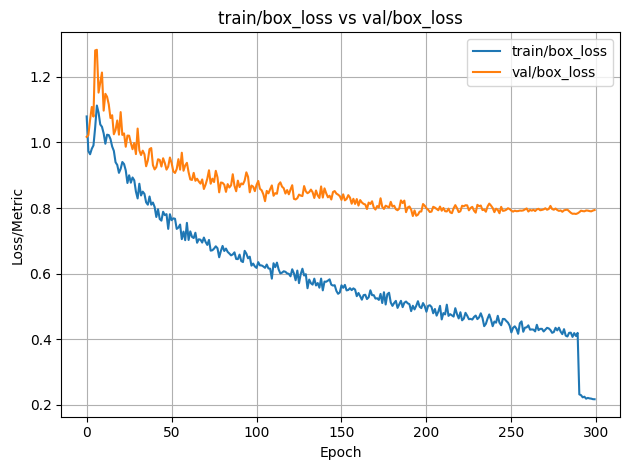

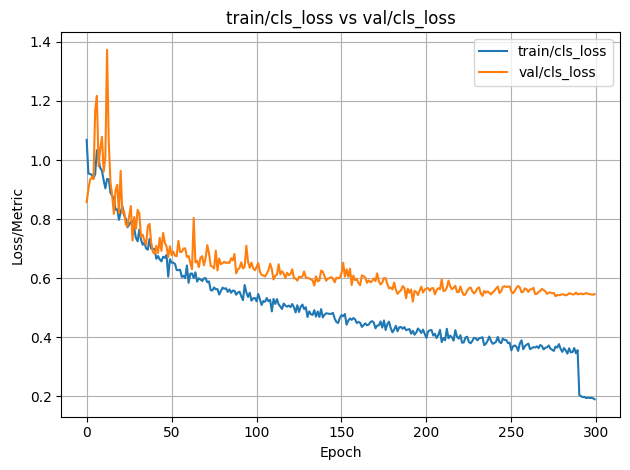

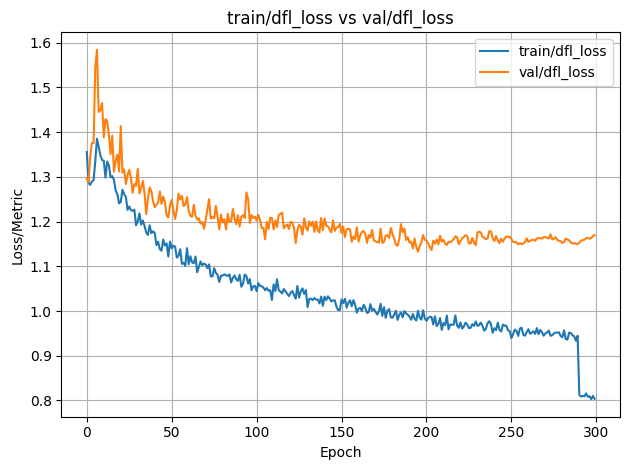

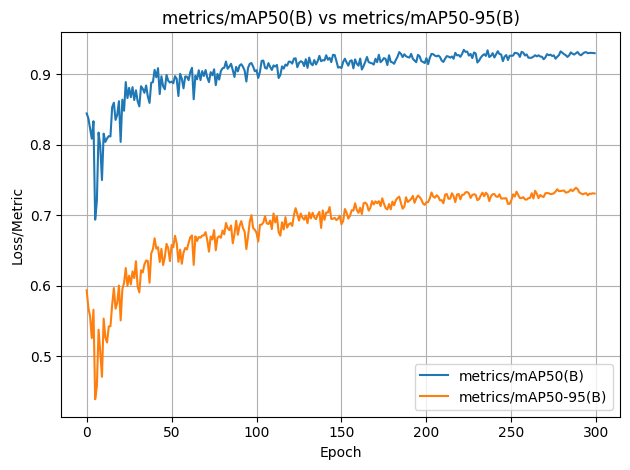

In [ ]:
import matplotlib.pyplot as plt
# 시각화할 주요 지표
metrics_to_plot = [
    ('train/box_loss', 'val/box_loss'),
    ('train/cls_loss', 'val/cls_loss'),
    ('train/dfl_loss', 'val/dfl_loss'),
    ('metrics/mAP50(B)', 'metrics/mAP50-95(B)')
]

# 그래프 그리기
for train_metric, val_metric in metrics_to_plot:
    if train_metric in result.columns and val_metric in result.columns:
        plt.figure()
        plt.plot(result[train_metric], label=train_metric)
        plt.plot(result[val_metric], label=val_metric)
        plt.xlabel('Epoch')
        plt.ylabel('Loss/Metric')
        plt.title(f'{train_metric} vs {val_metric}')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    else:
        print(f"❌ 열이 존재하지 않습니다: {train_metric} 또는 {val_metric}")